In [1]:
import numpy as np
import scipy.io

file = '10km_16QAM_28_3.mat'

# Load the .mat file as a numpy array
data = scipy.io.loadmat(file)

# Print the shape of the loaded data
print({key: value.shape for key, value in data.items() if isinstance(value, np.ndarray)})

{'dataToSave': (99990, 2)}


In [2]:
# Extract the array from the data dictionary
dataToSave = data['dataToSave']

input = dataToSave[:, 0].reshape(-1, 1)  # Use the first column as input (complex numbers)

label = dataToSave[:, 1].reshape(-1, 1)  # Use the second column as output (complex numbers)

In [3]:
### Hyperparameter Configuration ###
# Model hyperparameters
NUM_TAPS = 21
NUM_EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2

# Data parameters
MODULATION_ORDER = 16
TEST_SIZE = 0.3
RANDOM_STATE = 42

print(f"Configuration:")
print(f"  Modulation: {MODULATION_ORDER}QAM")
print(f"  Num Taps: {NUM_TAPS}")
print(f"  Num Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")

Configuration:
  Modulation: 16QAM
  Num Taps: 21
  Num Epochs: 100
  Batch Size: 256
  Learning Rate: 0.001


In [4]:
### Load transmitted bits for BER calculation ###
# Load the transmitted bits from the Tx_Waveform_and_Bits folder
if MODULATION_ORDER == 4:
    tx_bits_file = 'Tx_Waveform_and_Bits/QPSK_bits.txt'
elif MODULATION_ORDER == 16:
    tx_bits_file = 'Tx_Waveform_and_Bits/16QAM_bits.txt'
elif MODULATION_ORDER == 32:
    tx_bits_file = 'Tx_Waveform_and_Bits/32QAM_bits.txt'
elif MODULATION_ORDER == 64:
    tx_bits_file = 'Tx_Waveform_and_Bits/64QAM_bits.txt'
else:
    raise ValueError(f"No bits file for modulation order {MODULATION_ORDER}")

tx_bits = np.loadtxt(tx_bits_file, dtype=np.uint8)
print(f"Loaded {len(tx_bits)} transmitted bits from {tx_bits_file}")
print(f"First 20 bits: {tx_bits[:20]}")

Loaded 400000 transmitted bits from Tx_Waveform_and_Bits/16QAM_bits.txt
First 20 bits: [1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.optim as optim

if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [6]:
# Import all model classes
from mlp_model import MLPEqualizer
from xgboost_model import XGBoostEqualizer
from lstm_model import LSTMEqualizer
from gru_model import GRUEqualizer
from transformer_model import TransformerEqualizer

In [7]:
### Train XGBoost Equalizer ###
print("="*60)
print("Training XGBoost Equalizer")
print("="*60)

xgboost_eq = XGBoostEqualizer(
    num_taps=NUM_TAPS,
    n_estimators=500,
    max_depth=12,  
    learning_rate=0.01,
    random_state=RANDOM_STATE
)

xgboost_results = xgboost_eq.train(input, label, tx_bits, MODULATION_ORDER, test_size=TEST_SIZE, verbose=True)

Training XGBoost Equalizer
Creating sliding window data for XGBoost...
Training XGBoost models...
Training complete.

--- XGBoost Results ---
MSE After EQ:  0.0098
R2 After EQ:   0.9902
BER After EQ:  5.818412e-03


In [8]:
### Train MLP Equalizer ###
print("\n" + "="*60)
print("Training MLP Equalizer")
print("="*60)

mlp_eq = MLPEqualizer(
    num_taps=NUM_TAPS,
    hidden_layer_size=HIDDEN_SIZE,
    max_iter=1000,
    random_state=RANDOM_STATE
)

mlp_results = mlp_eq.train(input, label, tx_bits, MODULATION_ORDER, test_size=TEST_SIZE, verbose=True)


Training MLP Equalizer
Creating sliding window data for MLP...
Training MLP model...
Training complete.

--- MLP Results ---
MSE After EQ:  0.0090
R2 After EQ:   0.9910
BER After EQ:  1.667167e-05


In [9]:
### Train LSTM Equalizer ###
print("\n" + "="*60)
print("Training LSTM Equalizer")
print("="*60)

lstm_eq = LSTMEqualizer(
    num_taps=NUM_TAPS,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    random_state=RANDOM_STATE
)

lstm_results = lstm_eq.train(input, label, tx_bits, MODULATION_ORDER, test_size=TEST_SIZE, verbose=True)


Training LSTM Equalizer
Using device: cuda
Creating sliding window data for LSTM...
Training LSTM model...
Epoch [10/100], Loss: 0.008599
Epoch [20/100], Loss: 0.007616
Epoch [30/100], Loss: 0.006985
Epoch [40/100], Loss: 0.006596
Epoch [50/100], Loss: 0.005596
Epoch [60/100], Loss: 0.002428
Epoch [70/100], Loss: 0.000270
Epoch [80/100], Loss: 0.000134
Epoch [90/100], Loss: 0.000075
Epoch [100/100], Loss: 0.000046
Training complete.

--- LSTM Results ---
MSE After EQ:  0.0000
R2 After EQ:   1.0000
BER After EQ:  8.335834e-06


In [10]:
### Train GRU Equalizer ###
print("\n" + "="*60)
print("Training GRU Equalizer")
print("="*60)

gru_eq = GRUEqualizer(
    num_taps=NUM_TAPS,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    random_state=RANDOM_STATE
)

gru_results = gru_eq.train(input, label, tx_bits, MODULATION_ORDER, test_size=TEST_SIZE, verbose=True)


Training GRU Equalizer
Using device: cuda
Creating sliding window data for GRU...
Training GRU model...
Epoch [10/100], Loss: 0.008327
Epoch [20/100], Loss: 0.008186
Epoch [30/100], Loss: 0.007449
Epoch [40/100], Loss: 0.007156
Epoch [50/100], Loss: 0.006693
Epoch [60/100], Loss: 0.005926
Epoch [70/100], Loss: 0.004933
Epoch [80/100], Loss: 0.003783
Epoch [90/100], Loss: 0.003285
Epoch [100/100], Loss: 0.002752
Training complete.

--- GRU Results ---
MSE After EQ:  0.0042
R2 After EQ:   0.9958
BER After EQ:  2.917542e-04


In [11]:
### Train Transformer Equalizer ###
print("\n" + "="*60)
print("Training Transformer Equalizer")
print("="*60)

transformer_eq = TransformerEqualizer(
    num_taps=NUM_TAPS,
    d_model=HIDDEN_SIZE,
    nhead=4,
    num_layers=NUM_LAYERS,
    dim_feedforward=256,
    dropout=0.1,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    random_state=RANDOM_STATE
)

transformer_results = transformer_eq.train(input, label, tx_bits, MODULATION_ORDER, test_size=TEST_SIZE, verbose=True)


Training Transformer Equalizer
Using device: cuda
Creating sliding window data for Transformer...
Training Transformer model...
Epoch [10/100], Loss: 0.004475
Epoch [20/100], Loss: 0.003065
Epoch [30/100], Loss: 0.002407
Epoch [40/100], Loss: 0.001336
Epoch [50/100], Loss: 0.000846
Epoch [60/100], Loss: 0.000617
Epoch [70/100], Loss: 0.000509
Epoch [80/100], Loss: 0.000409
Epoch [90/100], Loss: 0.000331
Epoch [100/100], Loss: 0.000289
Training complete.

--- Transformer Results ---
MSE After EQ:  0.0006
R2 After EQ:   0.9994
BER After EQ:  1.667167e-05


Figure saved as 'model_comparison_constellation.pdf'


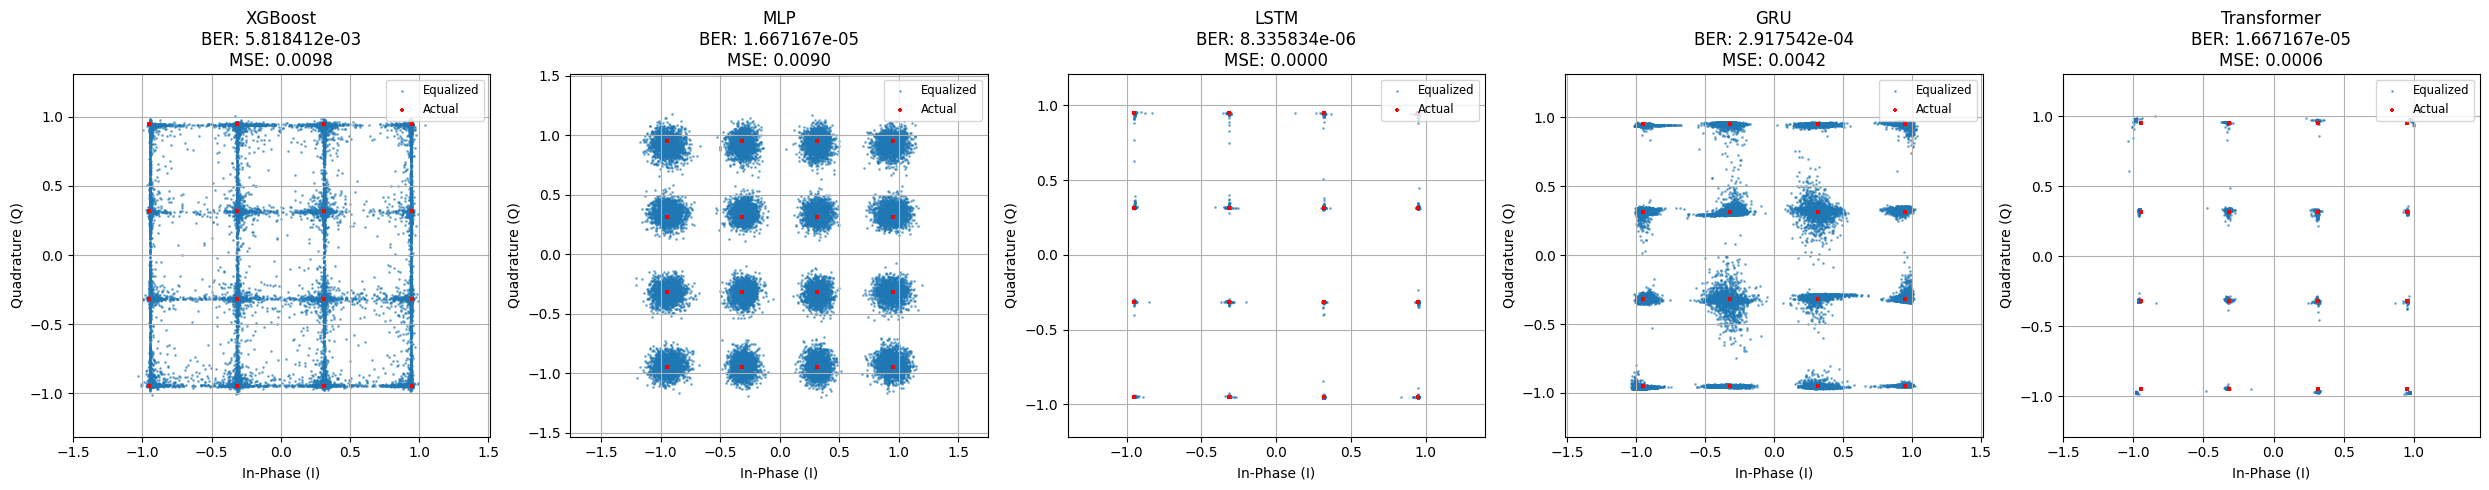


Model Performance Comparison (After Equalization)
Model        MSE          R2 Score     BER             Bit Errors     
------------------------------------------------------------------------------------------
XGBoost      0.0098       0.9902       5.818412e-03    698            
MLP          0.0090       0.9910       1.667167e-05    2              
LSTM         0.0000       1.0000       8.335834e-06    1              
GRU          0.0042       0.9958       2.917542e-04    35             
Transformer  0.0006       0.9994       1.667167e-05    2              


In [13]:
### Compare All Models ###
import matplotlib.pyplot as plt

# Collect all results - XGBoost first
all_results = [xgboost_results, mlp_results, lstm_results, gru_results, transformer_results]
model_names = ["XGBoost", "MLP", "LSTM", "GRU", "Transformer"]

# Create comparison plots - only showing After EQ
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, (results, name) in enumerate(zip(all_results, model_names)):
    # After equalization only
    axes[idx].scatter(results["eq_symbols"].real, results["eq_symbols"].imag, 
                     s=1, label='Equalized', alpha=0.5)
    axes[idx].scatter(results["actual_symbols"].real, results["actual_symbols"].imag, 
                     s=10, c='red', marker='+', label='Actual')
    axes[idx].set_title(f'{name}\nBER: {results["ber_after"]:.6e}\nMSE: {results["mse_after"]:.4f}')
    axes[idx].set_xlabel('In-Phase (I)')
    axes[idx].set_ylabel('Quadrature (Q)')
    axes[idx].legend(loc='upper right', fontsize='small')
    axes[idx].grid(True)
    axes[idx].axis('equal')

# plt.suptitle(f"{MODULATION_ORDER}QAM Model Comparison After Equalization", fontsize=16)
plt.tight_layout()

# Save as PDF for vector graphics
plt.savefig('model_comparison_constellation.pdf', format='pdf', bbox_inches='tight', dpi=300)
print("Figure saved as 'model_comparison_constellation.pdf'")

plt.show()

# Print comprehensive comparison table - After EQ only
print("\n" + "="*90)
print("Model Performance Comparison (After Equalization)")
print("="*90)
print(f"{'Model':<12} {'MSE':<12} {'R2 Score':<12} {'BER':<15} {'Bit Errors':<15}")
print("-"*90)
for results, name in zip(all_results, model_names):
    # Calculate number of bit errors for display
    k = int(np.log2(MODULATION_ORDER))
    num_test_symbols = len(results['eq_symbols'])
    num_test_bits = num_test_symbols * k
    num_errors = int(results['ber_after'] * num_test_bits)
    
    print(f"{name:<12} {results['mse_after']:<12.4f} {results['r2_after']:<12.4f} "
          f"{results['ber_after']:<15.6e} {num_errors:<15d}")

# Print improvement metrics from before to after EQ
# print("\n" + "="*90)
# print("Improvement Metrics (Before → After Equalization)")
# print("="*90)
# print(f"{'Model':<12} {'MSE Reduction':<20} {'R2 Gain':<20} {'BER Reduction':<20}")
# print("-"*90)
# for results, name in zip(all_results, model_names):
#     mse_reduction = ((results["mse_before"] - results["mse_after"]) / results["mse_before"] * 100)
#     r2_gain = results["r2_after"] - results["r2_before"]
#     ber_reduction = ((results["ber_before"] - results["ber_after"]) / results["ber_before"] * 100) if results["ber_before"] != 0 else 0
#     print(f"{name:<12} {mse_reduction:<20.2f}% {r2_gain:<20.4f} {ber_reduction:<20.2f}%")